In [1]:
# Import libraries
# GoogleNews Documentation : https://pypi.org/project/GoogleNews/
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from tqdm import tqdm
import pandas as pd
import nltk  # NLP library
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pyLDAvis.gensim_models
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import warnings

warnings.filterwarnings('ignore')
sns.set()
pyLDAvis.enable_notebook()

In [2]:
# This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anna_verbytska/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Config to avoid 403 forbidden error
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 20

In [4]:
# Initializing
googlenews = GoogleNews()

In [5]:
# Clear previous search
googlenews.clear()

In [14]:
# Settings
googlenews = GoogleNews(lang='en',start='01/07/2023',end='01/07/2023')

In [15]:
# Search 
googlenews.search('Ukraine')
print(f"Articles found:", googlenews.total_count())

Articles found: 46


In [16]:
# Results
result = googlenews.result()

In [17]:
# Convert to DataFrame
df = pd.DataFrame(result)
df.head(20)

,title,media,date,datetime,desc,link,img
0,,,,NaT,,https://support.google.com/websearch/answer/10...,
1,Ukraine war: The Christmas ceasefire that wasn't,BBC,4 weeks ago,2023-01-05 18:38:51.182633,"""They promised there would be one, but we don'...",https://www.bbc.com/news/world-europe-64199649,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Russia-Ukraine war at a glance: what we know o...,The Guardian,4 weeks ago,2023-01-05 18:38:51.188460,At least three killed in Russian attacks on Uk...,https://www.theguardian.com/world/2023/jan/08/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,Ukraine updates: Fighting goes on despite Russ...,DW,4 weeks ago,2023-01-05 18:38:51.193652,Ukrainian and Russian forces carried on fighti...,https://www.dw.com/en/ukraine-updates-fighting...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,West's military support has been crucial to Uk...,Anadolu Agency,4 weeks ago,2023-01-05 18:38:51.198359,Zelenskyy and his administration have also bee...,https://www.aa.com.tr/en/russia-ukraine-war/we...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,What type of armored vehicles are being sent t...,DW,4 weeks ago,2023-01-05 18:38:51.202744,Ukraine has repeatedly requested battle tanks ...,https://www.dw.com/en/what-type-of-armored-veh...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Did France surprise Germany by pledging tanks ...,France 24,4 weeks ago,2023-01-05 18:38:51.207010,A day after France announced it was sending We...,https://www.france24.com/en/europe/20230107-di...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,Ukraine celebrates Orthodox Christmas under th...,Vatican News,4 weeks ago,2023-01-05 18:38:51.211369,Prayers reverberated throughout the Holy Dormi...,https://www.vaticannews.va/en/church/news/2023...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,"Brutalised, broken, mended: inside Ukraine’s r...",The Guardian,4 weeks ago,2023-01-05 18:38:51.215431,"For those with spinal injuries, one centre is ...",https://www.theguardian.com/world/2023/jan/07/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Record food prices in 2022 due to Ukraine war ...,Euronews,4 weeks ago,2023-01-05 18:38:51.219243,Food prices hit record highs in 2022 due to th...,https://www.euronews.com/2023/01/07/record-foo...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [18]:
# Checking one article
df.iloc[8]['desc']

"For those with spinal injuries, one centre is offering a 'small miracle'. Now that miracle needs to expand… Ukraine war latest."

In [19]:
# Unfortunately there is a search limit on the number of news in this api. Maximum number is 10. Now, we will try to fetch more than that.
for i in tqdm(range(2,10), colour="red", desc="Getting news links from Google"):
  googlenews.getpage(i)
  result = googlenews.result()
  df = pd.DataFrame(result)

Getting news links from Google:  88%|████████▊ | 7/8 [00:04<00:00,  1.47it/s]

'NoneType' object is not iterable


Getting news links from Google: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

'NoneType' object is not iterable


In [20]:
df.head(15)

,title,media,date,datetime,desc,link,img
0,,,,NaT,,https://support.google.com/websearch/answer/10...,
1,Ukraine war: The Christmas ceasefire that wasn't,BBC,4 weeks ago,2023-01-05 18:38:51.182633,"""They promised there would be one, but we don'...",https://www.bbc.com/news/world-europe-64199649,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Russia-Ukraine war at a glance: what we know o...,The Guardian,4 weeks ago,2023-01-05 18:38:51.188460,At least three killed in Russian attacks on Uk...,https://www.theguardian.com/world/2023/jan/08/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,Ukraine updates: Fighting goes on despite Russ...,DW,4 weeks ago,2023-01-05 18:38:51.193652,Ukrainian and Russian forces carried on fighti...,https://www.dw.com/en/ukraine-updates-fighting...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,West's military support has been crucial to Uk...,Anadolu Agency,4 weeks ago,2023-01-05 18:38:51.198359,Zelenskyy and his administration have also bee...,https://www.aa.com.tr/en/russia-ukraine-war/we...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,What type of armored vehicles are being sent t...,DW,4 weeks ago,2023-01-05 18:38:51.202744,Ukraine has repeatedly requested battle tanks ...,https://www.dw.com/en/what-type-of-armored-veh...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Did France surprise Germany by pledging tanks ...,France 24,4 weeks ago,2023-01-05 18:38:51.207010,A day after France announced it was sending We...,https://www.france24.com/en/europe/20230107-di...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,Ukraine celebrates Orthodox Christmas under th...,Vatican News,4 weeks ago,2023-01-05 18:38:51.211369,Prayers reverberated throughout the Holy Dormi...,https://www.vaticannews.va/en/church/news/2023...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,"Brutalised, broken, mended: inside Ukraine’s r...",The Guardian,4 weeks ago,2023-01-05 18:38:51.215431,"For those with spinal injuries, one centre is ...",https://www.theguardian.com/world/2023/jan/07/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Record food prices in 2022 due to Ukraine war ...,Euronews,4 weeks ago,2023-01-05 18:38:51.219243,Food prices hit record highs in 2022 due to th...,https://www.euronews.com/2023/01/07/record-foo...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [21]:
# Remove some weird rows
df = df[df['datetime'].notnull()]
df.head(15)

,title,media,date,datetime,desc,link,img
1,Ukraine war: The Christmas ceasefire that wasn't,BBC,4 weeks ago,2023-01-05 18:38:51.182633,"""They promised there would be one, but we don'...",https://www.bbc.com/news/world-europe-64199649,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Russia-Ukraine war at a glance: what we know o...,The Guardian,4 weeks ago,2023-01-05 18:38:51.188460,At least three killed in Russian attacks on Uk...,https://www.theguardian.com/world/2023/jan/08/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,Ukraine updates: Fighting goes on despite Russ...,DW,4 weeks ago,2023-01-05 18:38:51.193652,Ukrainian and Russian forces carried on fighti...,https://www.dw.com/en/ukraine-updates-fighting...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,West's military support has been crucial to Uk...,Anadolu Agency,4 weeks ago,2023-01-05 18:38:51.198359,Zelenskyy and his administration have also bee...,https://www.aa.com.tr/en/russia-ukraine-war/we...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,What type of armored vehicles are being sent t...,DW,4 weeks ago,2023-01-05 18:38:51.202744,Ukraine has repeatedly requested battle tanks ...,https://www.dw.com/en/what-type-of-armored-veh...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Did France surprise Germany by pledging tanks ...,France 24,4 weeks ago,2023-01-05 18:38:51.207010,A day after France announced it was sending We...,https://www.france24.com/en/europe/20230107-di...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,Ukraine celebrates Orthodox Christmas under th...,Vatican News,4 weeks ago,2023-01-05 18:38:51.211369,Prayers reverberated throughout the Holy Dormi...,https://www.vaticannews.va/en/church/news/2023...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,"Brutalised, broken, mended: inside Ukraine’s r...",The Guardian,4 weeks ago,2023-01-05 18:38:51.215431,"For those with spinal injuries, one centre is ...",https://www.theguardian.com/world/2023/jan/07/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Record food prices in 2022 due to Ukraine war ...,Euronews,4 weeks ago,2023-01-05 18:38:51.219243,Food prices hit record highs in 2022 due to th...,https://www.euronews.com/2023/01/07/record-foo...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
10,London to host international meeting on allege...,Reuters,4 weeks ago,2023-01-05 18:38:51.222972,Britain has been steady in its backing for Ukr...,https://www.reuters.com/world/london-host-inte...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [22]:
# Get the full article extracting and parsing the article and drop the links that give problems

list = []

for ind in tqdm(df.index, colour="green", desc="Extracting articles from the internet"):
  dict = {}
  
  try:
    article = Article(df['link'][ind],config = config)
    article.download()
    article.parse()
    article.nlp()
    dict['Date'] = df['date'][ind]
    dict['Media'] = df['media'][ind]
    dict['Title'] = article.title
    dict['Article'] = article.text
    dict['Summary'] = article.summary
    list.append(dict)
  except Exception:
    df.drop([ind],axis=0,inplace=True)



Extracting articles from the internet: 100%|██████████| 68/68 [01:49<00:00,  1.61s/it]


In [23]:
# Create the news dataframe with full articles
news_df = pd.DataFrame(list)
news_df.head(20)

,Date,Media,Title,Article,Summary
0,4 weeks ago,BBC,Ukraine war: The Christmas ceasefire that wasn't,Russian forces are on the eastern edge of the ...,Russian forces are on the eastern edge of the ...
1,4 weeks ago,The Guardian,Russia-Ukraine war at a glance: what we know o...,Russian attacks were reported in at least seve...,Russian troops shelled the Kherson region 39 t...
2,4 weeks ago,DW,Ukraine updates: Fighting goes on despite Russ...,Ukrainian and Russian forces carried on fighti...,Ukrainian and Russian forces carried on fighti...
3,4 weeks ago,Anadolu Agency,West’s military support has been crucial to Uk...,Necessary Cookies\n\nThis cookie is used to di...,Necessary CookiesThis cookie is used to distin...
4,4 weeks ago,DW,What type of armored vehicles are being sent t...,"After months of wavering, Germany and the Unit...","After months of wavering, Germany and the Unit..."
5,4 weeks ago,France 24,Did France surprise Germany by pledging tanks ...,TANK DIPLOMACY\n\nA French army AMX 10 RC tank...,A day after France announced it was sending We...
6,4 weeks ago,Vatican News,Ukraine celebrates Orthodox Christmas under th...,Church services have begun in Ukraine to mark ...,Church services have begun in Ukraine to mark ...
7,4 weeks ago,The Guardian,"Brutalised, broken, mended: inside Ukraine’s r...",Dmytro Polovian laughed as one of his doctors ...,The centre is the only one in Ukraine dedicate...
8,4 weeks ago,Euronews,Record food prices in 2022 due to Ukraine war ...,Food prices hit record highs in 2022 due to th...,Food prices hit record highs in 2022 due to th...
9,4 weeks ago,Reuters,London to host international meeting on allege...,"\n\n\n\n\n\n\n\n\n\n\n\n\n\nLONDON, Jan 7 (Reu...","LONDON, Jan 7 (Reuters) - Justice ministers fr..."


In [24]:
# Checking one article
news_df.iloc[8]['Article']

"Food prices hit record highs in 2022 due to the outbreak of war in Ukraine and droughts linked to climate change.\n\nWorld prices for commodities like grain and vegetable oils were the highest on record last year, according to the UN Food and Agriculture Organisation (FAO).\n\nDroughts across large parts of the planet, driven by global warming, Russia's invasion of Ukraine in February and other factors are fuelling the inflationary pressure, which is worsening hunger worldwide.\n\nOn Thursday, the UN Development Programme reported that 71 million more people around the world are experiencing poverty as a result of soaring food and energy prices.\n\nThe FAO Food Price Index, which tracks monthly changes in the international prices of common food stuffs, averaged 143.7 points in 2022, meaning food prices were more than 14% above the 2021 average.\n\nThis comes on top of a 28% increase in world food prices recorded by the FAO that year.\n\nTheir pricing system is based on five major comm

# Topic Modelling

In [25]:
#Running a model
nlp = en_core_web_md.load()

In [26]:
#Removing stopwords
removal= ['PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

In [27]:
#Lemmatization & tokenization
tokens = []
for article in nlp.pipe(news_df['Article']):
	proj_tok = [token.lemma_.lower() for token in article if token.pos_ not in removal and not token.is_stop and token.is_alpha]
	tokens.append(proj_tok)

In [28]:
#Printing out tokens
news_df['tokens'] = tokens
news_df['tokens']

0     [russian, force, eastern, edge, city, little, ...
1     [russian, attack, report, region, ukraine, eas...
2     [ukrainian, russian, force, carry, fight, exch...
3     [necessary, cookie, cookie, distinguish, human...
4     [month, wavering, germany, united, states, wan...
                            ...                        
59    [russia, attack, ukraine, orthodox, christmas,...
60    [kyiv, ukraine, fighting, rage, eastern, ukrai...
61                                                   []
62    [go, wrong, try, later, invalid, email, go, wr...
63    [ukraine, conscientious, objector, coward, tra...
Name: tokens, Length: 64, dtype: object

In [29]:
#Creating a dictionary, giving each token a unique ID
dictionary = Dictionary(news_df['tokens'])
print(dictionary.token2id)

{'attempt': 0, 'away': 1, 'bakhmut': 2, 'city': 3, 'eastern': 4, 'edge': 5, 'fall': 6, 'force': 7, 'little': 8, 'mile': 9, 'push': 10, 'russian': 11, 'summer': 12, 'throw': 13, 'try': 14, 'west': 15, 'accord': 16, 'adviser': 17, 'aid': 18, 'air': 19, 'allege': 20, 'announce': 21, 'apparent': 22, 'armoured': 23, 'ask': 24, 'assistance': 25, 'attack': 26, 'base': 27, 'big': 28, 'black': 29, 'bradley': 30, 'building': 31, 'capital': 32, 'casualty': 33, 'cathedral': 34, 'ceasefire': 35, 'christmas': 36, 'civilian': 37, 'combat': 38, 'come': 39, 'commercial': 40, 'continue': 41, 'conversation': 42, 'country': 43, 'crimean': 44, 'daily': 45, 'date': 46, 'dead': 47, 'declaration': 48, 'defence': 49, 'describe': 50, 'despite': 51, 'devolve': 52, 'dismount': 53, 'dollar': 54, 'dormition': 55, 'drone': 56, 'early': 57, 'east': 58, 'epiphanius': 59, 'exactly': 60, 'explosion': 61, 'fighting': 62, 'fire': 63, 'fleet': 64, 'focus': 65, 'forested': 66, 'francesco': 67, 'friday': 68, 'frontline': 69,

In [30]:
#Filtering out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [31]:
#Creating a corpus
corpus = [dictionary.doc2bow(doc) for doc in news_df['tokens']]

In [32]:
#Building a model with LDA that represents topics as word probabilities and allows for uncovering latent or hidden topics as it clusters the words based on their co-occurrence in a respective document
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

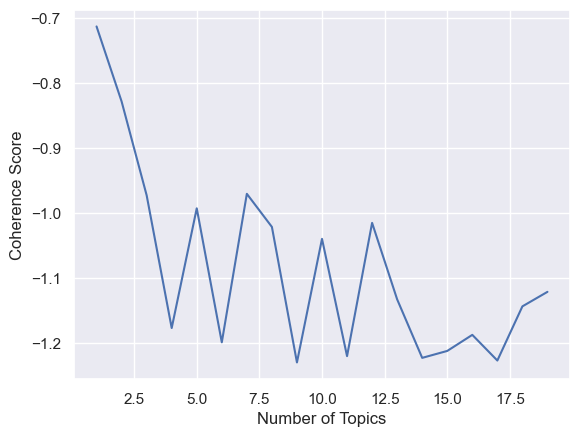

In [33]:
#Calculating the coherence score using C_umass to measure the degree of semantic similarity between high scoring words in each topic
topics = []
score = []
for i in range (1,20,1):   
  lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)   
  cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')   
  topics.append(i)
  score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

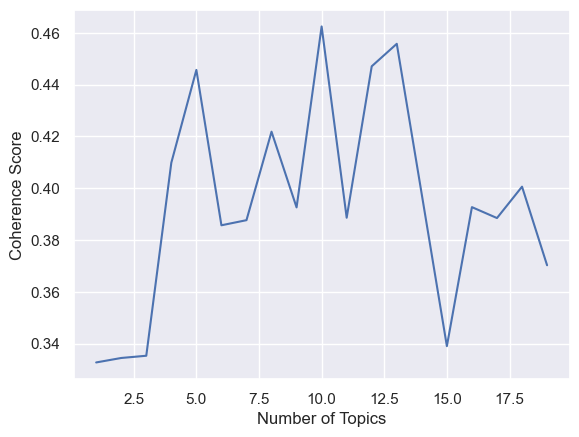

In [34]:
#Calculating the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):  
  lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)   
  cm = CoherenceModel(model=lda_model, texts = news_df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')   
  topics.append(i)
  score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [35]:
#Printing out the results
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=6, workers = 4, passes=100)
for top in lda_model.print_topics(10):
  print(top)

(0, '0.019*"tank" + 0.015*"vehicle" + 0.014*"germany" + 0.013*"send" + 0.011*"fighting" + 0.010*"photo" + 0.009*"bakhmut" + 0.009*"month" + 0.009*"military" + 0.009*"images"')
(1, '0.026*"christmas" + 0.025*"orthodox" + 0.015*"fire" + 0.013*"saturday" + 0.013*"force" + 0.011*"fighting" + 0.011*"military" + 0.011*"report" + 0.010*"region" + 0.010*"putin"')
(2, '0.024*"putin" + 0.012*"country" + 0.009*"system" + 0.009*"government" + 0.009*"collapse" + 0.009*"power" + 0.008*"carrier" + 0.008*"state" + 0.008*"soviet" + 0.008*"end"')
(3, '0.044*"price" + 0.031*"food" + 0.015*"world" + 0.014*"grain" + 0.014*"support" + 0.014*"country" + 0.013*"record" + 0.013*"contact" + 0.013*"january" + 0.012*"help"')
(4, '0.020*"military" + 0.013*"kyiv" + 0.012*"new" + 0.011*"january" + 0.010*"putin" + 0.010*"missile" + 0.009*"month" + 0.009*"troop" + 0.009*"report" + 0.009*"air"')
(5, '0.017*"peace" + 0.013*"talk" + 0.012*"new" + 0.011*"country" + 0.010*"need" + 0.010*"world" + 0.010*"help" + 0.009*"work

In [36]:
#Distribution of topics in a document
lda_model[corpus][0]

[(0, 0.012122404),
 (1, 0.012066225),
 (2, 0.011990256),
 (3, 0.9398671),
 (4, 0.011994919),
 (5, 0.011959145)]

In [37]:
#Visualization of topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [38]:
#Creating a new column for topics
news_df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(news_df['Article']))]

In [39]:
#Counting frequency of every topic in a document
news_df.topic.value_counts()

0    30
1    17
4     6
2     5
5     4
3     2
Name: topic, dtype: int64

In [40]:
news_df.head()

,Date,Media,Title,Article,Summary,tokens,topic
0,4 weeks ago,BBC,Ukraine war: The Christmas ceasefire that wasn't,Russian forces are on the eastern edge of the ...,Russian forces are on the eastern edge of the ...,"[russian, force, eastern, edge, city, little, ...",0
1,4 weeks ago,The Guardian,Russia-Ukraine war at a glance: what we know o...,Russian attacks were reported in at least seve...,Russian troops shelled the Kherson region 39 t...,"[russian, attack, report, region, ukraine, eas...",1
2,4 weeks ago,DW,Ukraine updates: Fighting goes on despite Russ...,Ukrainian and Russian forces carried on fighti...,Ukrainian and Russian forces carried on fighti...,"[ukrainian, russian, force, carry, fight, exch...",1
3,4 weeks ago,Anadolu Agency,West’s military support has been crucial to Uk...,Necessary Cookies\n\nThis cookie is used to di...,Necessary CookiesThis cookie is used to distin...,"[necessary, cookie, cookie, distinguish, human...",1
4,4 weeks ago,DW,What type of armored vehicles are being sent t...,"After months of wavering, Germany and the Unit...","After months of wavering, Germany and the Unit...","[month, wavering, germany, united, states, wan...",0
